# SigPy for pTx Pulse Design

Welcome to RF pulse design for MRI in SigPy! SigPy is a powerful Python package for signal processing, with an emphasis on iterative methods. Though originally built with an emphasis on iterative reconstruction of MRI images, many of the tools within SigPy and abstractions used by the toolbox ([Linops](https://sigpy.readthedocs.io/en/latest/core_linop.html), [Proximal Operators](https://sigpy.readthedocs.io/en/latest/core_prox.html), [Iterative Algorithms](https://sigpy.readthedocs.io/en/latest/core_alg.html), and [Apps](https://sigpy.readthedocs.io/en/latest/core_app.html)) make it ideally suited for RF pulse design problems. Furthermore, as you will see, many RF pulse design problems are mathematically very similiar to common MRI reconstruction problems! 

Pairing SigPy's reconstruction tools with our new RF pulse designers moves the toolbox closer towards being able to simulate the entire imaging pipeline, from acquisition to recon. In this example, we will demonstrate a pairing of a reduced FOV (rFOV) spatial-domain parallel transmit (pTx) pulse design with gridding reconstruction tools already in SigPy.

# Setup

SigPy can be installed through pip or conda. Please note that many of the features discussed today are found in the [sigpy-rf fork](https://github.com/jonbmartin/sigpy-rf) and are not yet part of the package; they will soon be made available in the [main repository](https://github.com/mikgroup/sigpy).

SigPy is designed to use along with NumPy. In particular, SigPy operates on NumPy arrays directly, and relies on NumPy to provide basic data manipulation functions. Almost aways, we will import NumPy along with SigPy.

In [8]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr
import scipy.ndimage.filters as filt
import matplotlib.pyplot as mplib

Let us assume that our system has a known set of B1+ sensitivities; we will simulate these with SigPy. 

<IPython.core.display.Javascript object>


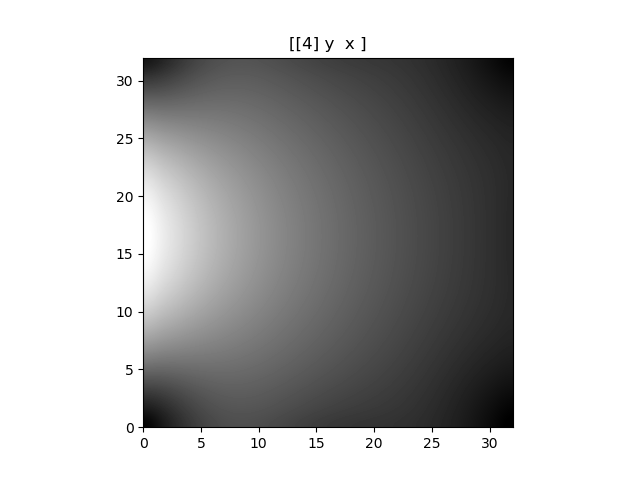

In [5]:

dim = 32
Nc = 8
img_shape = [dim, dim]
sens_shape = [Nc, dim, dim]
sens = mr.sim.birdcage_maps(sens_shape)
pl.ImagePlot(sens)

Step 1: Set up our spiral trajectory, using Sigpy's trajectory function.

Pulse trajectory parameters and spiral design:

<IPython.core.display.Javascript object>


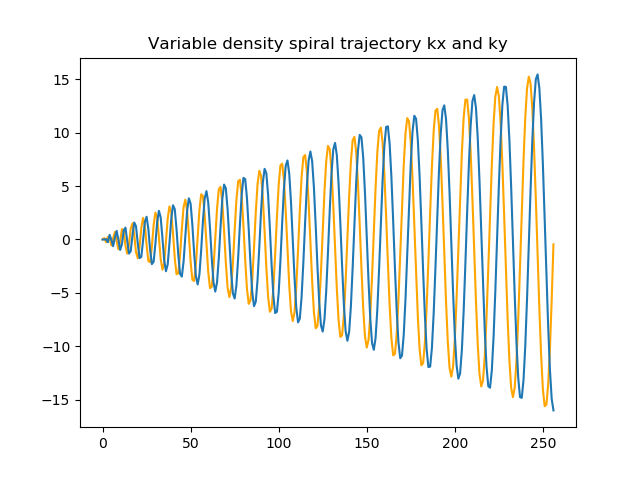

Text(0.5, 1.0, 'Variable density spiral trajectory kx and ky')

In [5]:
fov = dim/2
f_sampling = 1 # undersampling factor in freq encoding direction
R = 1 # spiral undersampling factor
ninterleaves = 1 # number of spiral interleaves- typically 1 for pulse design
alpha = 1.5 # variable density factor
gm = 0.03 # max gradient amplitude (T/m)
sm = 200 # maximum slew rate (T/m/s)

traj = mr.spiral(fov, img_shape, f_sampling, R,
                 ninterleaves, alpha, gm, sm)

mplib.figure()
mplib.plot(traj[:,0], color='orange')
mplib.plot(traj[:,1])
mplib.title('Variable density spiral trajectory kx and ky')

Step 2: Choose our target pattern: a circular region in the middle of our FOV. 

We will blur the pattern in order to avoid ripple artifacts.

<IPython.core.display.Javascript object>


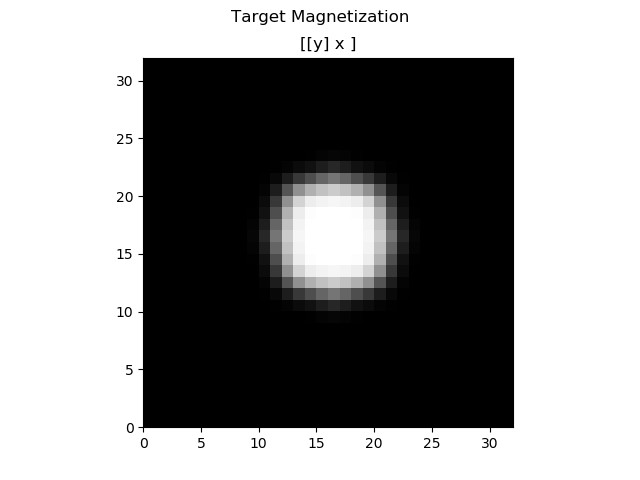

In [6]:
x, y = np.ogrid[-img_shape[0] / 2: img_shape[0] - img_shape[0] / 2,
       -img_shape[1] / 2: img_shape[1] - img_shape[1] / 2]
circle = x * x + y * y <= int(img_shape[0] / 6) ** 2
target = np.zeros(img_shape)
target[circle] = 1
target = filt.gaussian_filter(target, 1)
target = target.astype(np.complex)

pl.ImagePlot(target, title='Target Magnetization',interpolation='nearest')

Step 3: Put these pieces together and design our pulses using Sigpy. View a representative pulse.

In [12]:
pulses = mr.app.SmallTipSpatialPulseDesign(target,sens,coord=traj, lamda = 0.01,
                                            max_iter=1000, tol=1e-3,
                                            show_pbar=True, device=-1).run()

<IPython.core.display.Javascript object>


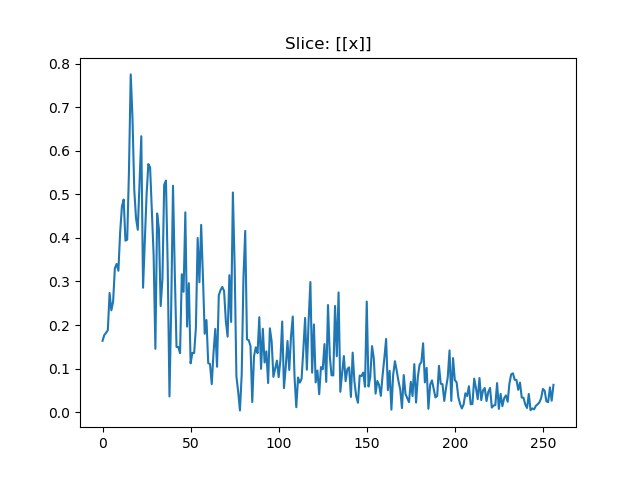

In [13]:
pl.LinePlot(pulses[0,:])

<IPython.core.display.Javascript object>


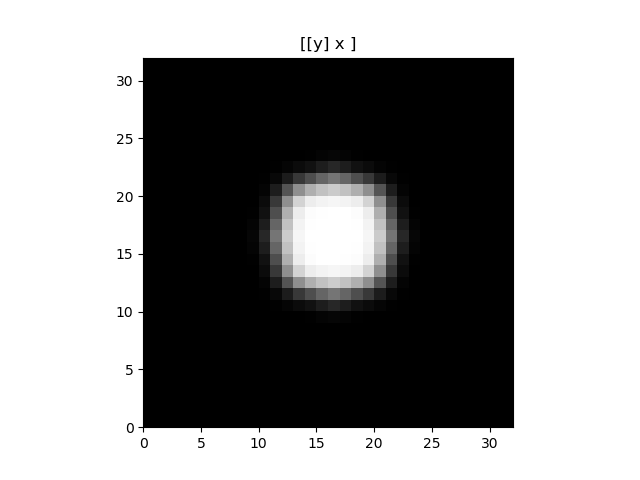

<IPython.core.display.Javascript object>


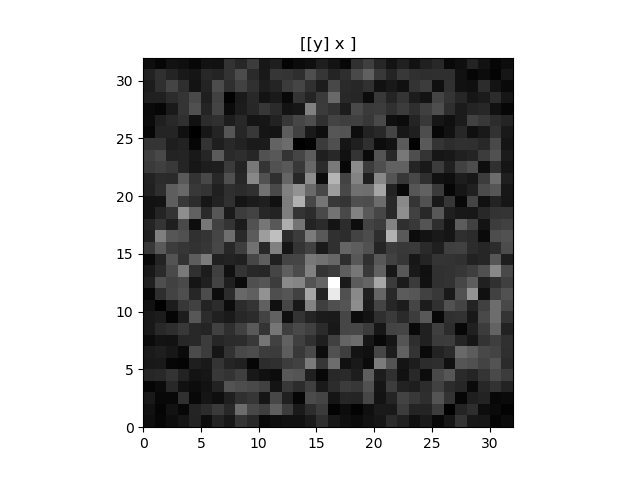

In [14]:
A = mr.linop.Sense(sens, coord=traj, ishape=target.shape).H

m = A * pulses

pl.ImagePlot(m, interpolation='nearest')
pl.ImagePlot(target-m, mode='m', interpolation='nearest')